<h1> Digit Recognizer using Convolution Neural Network </h1>


From Kaggle competition

We will start import the module as per normal

In [1]:
import numpy as np
from __future__ import print_function
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression

Next, we will load the given data get from kaggle website

In [2]:
from sklearn.model_selection import train_test_split
def onehotEncode(labels):
    return (np.arange(10) == labels[:,None]).astype(np.float32)

def loadData(train,test,train_valid_ratio=0.2):
    _data = pd.read_csv(train)
    _test = pd.read_csv(test)
    _data_dt = _data.drop('label',axis=1).values
    #_test_dt = _test.drop('label',axis=1).values
    _test_dt = _test.values
    _data_lb = _data['label'].values
    #_test_lb = _test['label'].values
    _data_lb = onehotEncode(_data_lb)
    #_test_lb = reformat(_test_lb)
    train_dt, valid_dt, train_lb, valid_lb \
    = train_test_split(_data_dt, _data_lb, test_size = train_valid_ratio, random_state=42)
    return train_dt, train_lb, valid_dt, valid_lb, _test_dt

tr_x, tr_y, v_x, v_y, ts = loadData("train.csv","test.csv")
print("Training data set {} - {}".format(tr_x.shape,tr_y.shape))
print("Validation data set {} - {}".format(v_x.shape,v_y.shape))
print("Test data set {} ".format(ts.shape))

Training data set (33600, 784) - (33600, 10)
Validation data set (8400, 784) - (8400, 10)
Test data set (28000, 784) 


We will try to visualize one of the given data.

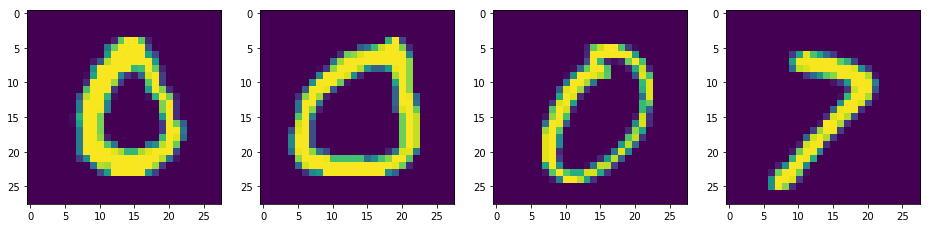

In [3]:
randomRow = np.random.randint(len(tr_x), size=4)
to_visualize = tr_x[randomRow,:]
imgList = []
plt.figure(figsize=[16,6])
for n,img in enumerate(to_visualize):
    plt.subplot(1,4,n+1)
    plt.imshow(img.reshape(28,28))


To train a convolutional neural network, we will need to reformat all data into 4-D tensor. Based on Udacity convolutional network.

In [4]:
image_size = 28
num_labels = 10
num_channels = 1

def reformat(dataset):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  return dataset

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

train_data = reformat(tr_x)
train_label = tr_y
valid_data = reformat(v_x)
valid_label = v_y
test_data = reformat(ts)
print("Training data set {} - {}".format(train_data.shape,train_label.shape))
print("Validation data set {} - {}".format(valid_data.shape,valid_label.shape))
print("Test data set {} ".format(test_data.shape))

Training data set (33600, 28, 28, 1) - (33600, 10)
Validation data set (8400, 28, 28, 1) - (8400, 10)
Test data set (28000, 28, 28, 1) 


In [ ]:
import tensorflow as tf

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
l3_dropout = 0.75
depth2 = 32
beta_1 = 1e-5
beta_2 = 1e-5
beta_3 = 1e-5
beta_o = 1e-5


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_data)
  tf_test_dataset = tf.constant(test_data)
  
  #Another Way of Defining Variables
  weights = { # 5x5 conv2, 1 input, 16 output
              'l1_w' : tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth],stddev=0.1)),
              # 5x5 conv2, 16 input, 16 output
              'l2_w' : tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth2],stddev=0.1)),
              # fully connected, 7*7*16 = 784 input, 64 output
              'l3_w' : tf.Variable(tf.truncated_normal([image_size//2*image_size//2*depth, num_hidden], stddev=0.1)),
              # output layer, 64 input, 10 output (class prediction)
              'o_w'  : tf.Variable(tf.truncated_normal([num_hidden, num_labels],stddev=0.1))}
  
  # shape of biases of each layer need to be the same as the output
  biases = { 'l1_b' : tf.Variable(tf.zeros([depth])),
             'l2_b' : tf.Variable(tf.constant(1.0, shape=[depth2])),
             'l3_b' : tf.Variable(tf.constant(1.0, shape=[num_hidden])),
             'o_b'  : tf.Variable(tf.constant(1.0, shape=[num_labels]))}

  def conv2d(x, W, b, strideC = 2):
    res = tf.nn.conv2d(x, W, [1,2,2,1],padding='SAME')
    res = tf.nn.relu(tf.nn.bias_add(res,b))
    return res

  def maxpool2d(x, k=1):
    res = tf.nn.max_pool(x, ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')
    return res
  
  def deep_convnet(x, weights, biases, dropout):
    # First convolution layer (l1)
    flow = conv2d(x,weights['l1_w'],biases['l1_b'])
    #print ("after 1st convo",flow.get_shape())
    flow = maxpool2d(flow)
    #print ("after 1st maxpool",flow.get_shape())
    
    # Second convolution layer (l2)
    '''
    flow = conv2d(flow,weights['l2_w'],biases['l2_b'])
    print ("after 2nd convo",flow.get_shape())
    flow = maxpool2d(flow)
    print ("after 2nd maxpool",flow.get_shape())
    '''
    
    # Reshaping layer (l3)
    shape = flow.get_shape().as_list()
    flow = tf.reshape(flow, [shape[0], shape[1] * shape[2] * shape[3]])
    #print ("after reshape",flow.get_shape())
    flow = tf.nn.bias_add(tf.matmul(flow, weights['l3_w']), biases['l3_b'])
    flow = tf.nn.relu(flow)
    # Apply Dropout
    flow = tf.nn.dropout(flow,dropout)
    #print ("after layer 3",flow.get_shape())
    
    # Output Layer (o)
    out = tf.nn.bias_add(tf.matmul(flow, weights['o_w']), biases['o_b'])
    return out 
    
  # Training computation.
  logits = deep_convnet(tf_train_dataset, weights, biases, l3_dropout)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Calculate the loss with regularization
  
  loss += beta_1 * tf.nn.l2_loss(weights['l1_w']) + \
    beta_3 * tf.nn.l2_loss(weights['l3_w']) + \
    beta_o * tf.nn.l2_loss(weights['o_w'])
  
  
  # Learn with exponential rate decay.
  #global_step = tf.Variable(0, trainable=False)
  #starter_learning_rate = 0.4
  #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96, staircase=True)
  learning_rate = 0.005
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(deep_convnet(tf_valid_dataset, weights, biases, l3_dropout))
  test_prediction = tf.nn.softmax(deep_convnet(tf_test_dataset, weights, biases, l3_dropout))

In [ ]:
num_steps = 2101
np.random.seed(42)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  epoch = 51
  idx = np.arange(len(train_data))
  ii = 1
  X_tograph = []
  y_tograph = []
  for ii in range(epoch):
    #print("+++++++++++++++++++++++++++++++++++++++++++++++")
    np.random.shuffle(idx)
    train_datas = train_data[idx,:,:,:]
    train_labels = train_label[idx,:]
    for step in range(num_steps):
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      batch_data = train_datas[offset:(offset + batch_size), :, :, :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (ii % 10 == 0):
      print('+++++++++++++++Running the {} epoch+++++++++++++'.format(ii))  
      print('Minibatch loss at end epoch %d: %f' % (ii, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
              valid_prediction.eval(), valid_label))
      print("+++++++++++++++++++++++++++++++++++++++++++++++")
    X_tograph.append(ii)
    y_tograph.append(accuracy(valid_prediction.eval(), valid_label))
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  result = test_prediction.eval()

In [ ]:
%matplotlib inline
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(X_tograph, y_tograph)
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim((0,100))

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()

In [ ]:
def getitem(a):
    return max(range(len(a)),key=a.__getitem__)

a = getitem(result[0])
res = [getitem(result[ii]) for ii in range(len(result))]
idd = np.arange(1,len(res)+1)

df_res = pd.DataFrame()
df_res['ImageId']= idd
df_res['Label']=res
print(df_res.head())
df_res.to_csv("DR_submission_jimmy_jiang1.csv",index=False)

Right Now, I will try to build the simplified VGGNet simonyan et al as shown!

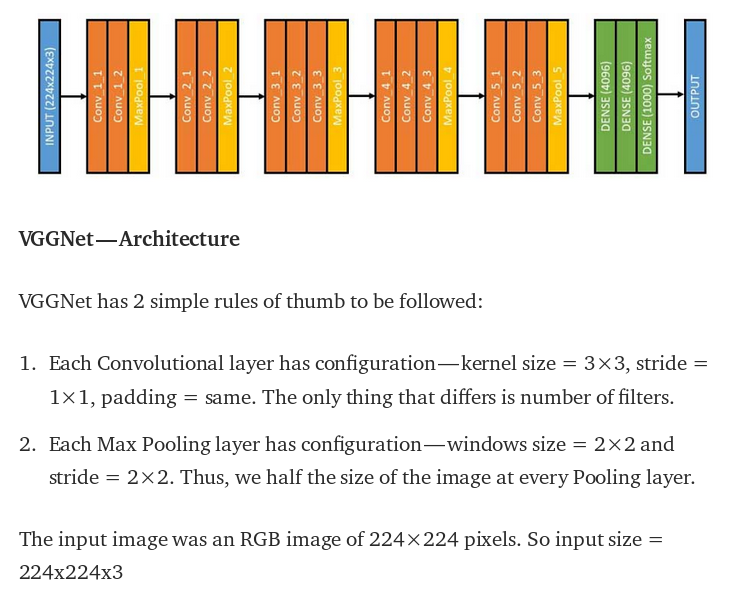

In [8]:
from IPython.display import Image
Image("Img/VGGNet.png")

In [12]:
def normalized(data):
    normal = []
    for jj in range(len(data)):
        normal.append([(x-128.)/128 for x in data[jj]])
    return normal

normal_tr_x = np.array(normalized(tr_x))
normal_v_x = np.array(normalized(v_x))
normal_ts = np.array(normalized(ts))

In [13]:
train_data = reformat(normal_tr_x)
train_label = tr_y
valid_data = reformat(normal_v_x)
valid_label = v_y
test_data = reformat(normal_ts)
print("Training data set {} - {}".format(train_data.shape,train_label.shape))
print("Validation data set {} - {}".format(valid_data.shape,valid_label.shape))
print("Test data set {} ".format(test_data.shape))

Training data set (33600, 28, 28, 1) - (33600, 10)
Validation data set (8400, 28, 28, 1) - (8400, 10)
Test data set (28000, 28, 28, 1) 


In [17]:
import tensorflow as tf

batch_size = 16
patch_size = 3
s1_depth = 64
s2_depth = 256
s3_depth = 1024
beta_11 = 1e-5
beta_12 = 1e-5
beta_21 = 1e-5
beta_22 = 1e-5
beta_31 = 1e-5
beta_32 = 1e-5
beta_4 = 1e-5
beta_5 = 1e-5
beta_o = 1e-5

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_data)
  tf_test_dataset = tf.constant(test_data)
  
  #Another Way of Defining Variables
  weights = { # 5x5 conv2, input : 28x28x1 , 16 output, stride = 2
              's1_1' : tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, s1_depth],stddev=0.1)),
              # 5x5 conv2, input : 14x14x16, 32 output, stride = 2
              's1_2' : tf.Variable(tf.truncated_normal([patch_size, patch_size, s1_depth, s1_depth],stddev=0.1)),
              # 5x5 conv2, input : 28x28x1 , 16 output, stride = 2
              's2_1' : tf.Variable(tf.truncated_normal([patch_size, patch_size, s1_depth, s2_depth],stddev=0.1)),
              # 5x5 conv2, input : 14x14x16, 32 output, stride = 2
              's2_2' : tf.Variable(tf.truncated_normal([patch_size, patch_size, s2_depth, s2_depth],stddev=0.1)),
              # 5x5 conv2, input : 28x28x1 , 16 output, stride = 2
              's3_1' : tf.Variable(tf.truncated_normal([patch_size, patch_size, s2_depth, s3_depth],stddev=0.1)),
              # 5x5 conv2, input : 14x14x16, 32 output, stride = 2
              's3_2' : tf.Variable(tf.truncated_normal([patch_size, patch_size, s3_depth, s3_depth],stddev=0.1)),
              # fully connected, input : 7*7*32 = 784 input, 64 output
              'l4_w' : tf.Variable(tf.truncated_normal([4*4*s3_depth, s3_depth*4], stddev=0.1)),
              # fully connected, input : 7*7*32 = 784 input, 64 output
              'l5_w' : tf.Variable(tf.truncated_normal([4*s3_depth, s3_depth], stddev=0.1)),                                          
              # output layer, 64 input, 10 output (class prediction)
              'o_w'  : tf.Variable(tf.truncated_normal([s3_depth, num_labels],stddev=0.1))}
  
  # shape of biases of each layer need to be the same as the output
  biases = { 's1_1' : tf.Variable(tf.zeros([s1_depth])),
             's1_2' : tf.Variable(tf.constant(1.0, shape=[s1_depth])),
             's2_1' : tf.Variable(tf.zeros([s2_depth])),
             's2_2' : tf.Variable(tf.constant(1.0, shape=[s2_depth])),
             's3_1' : tf.Variable(tf.zeros([s3_depth])),
             's3_2' : tf.Variable(tf.constant(1.0, shape=[s3_depth])),
             'l4_b' : tf.Variable(tf.constant(1.0, shape=[s3_depth*4])),
             'l5_b' : tf.Variable(tf.constant(1.0, shape=[s3_depth])),
             'o_b'  : tf.Variable(tf.constant(1.0, shape=[num_labels]))}

  probabilities = { 'p4' : 0.5 , 'p5' : 0.7}

  def stage_conv2d(x, W1, W2, b1, b2):
    res = tf.nn.conv2d(x, W1, [1,1,1,1],padding='SAME')
    res = tf.nn.relu(tf.nn.bias_add(res,b1))
    res = tf.nn.conv2d(res, W2, [1,1,1,1],padding='SAME')
    res = tf.nn.relu(tf.nn.bias_add(res,b2))
    res = tf.nn.max_pool(res, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
    return res
  
  def dense_layer_dropout(x,W,b,p):
    x = tf.nn.bias_add(tf.matmul(x, W), b)
    x = tf.nn.relu(x)
    return tf.nn.dropout(x,rate=p)
    
  def flatten_layer(x):
    shape = x.get_shape().as_list()
    return tf.reshape(x, [shape[0], shape[1] * shape[2] * shape[3]])
    
  def deep_convnet(x, weights, biases, probabilities):
    # First convolution layer (l1)
    flow = stage_conv2d(x,weights['s1_1'],weights['s1_2'],biases['s1_1'],biases['s1_2'])
    print ("after 1st convo",flow.get_shape())
    
    # Second convolution layer (l2)
    flow = stage_conv2d(flow,weights['s2_1'],weights['s2_2'],biases['s2_1'],biases['s2_2'])
    print ("after 2st convo",flow.get_shape())
                                                        
    # Third convolution layer (l3)
    flow = stage_conv2d(flow,weights['s3_1'],weights['s3_2'],biases['s3_1'],biases['s3_2'])
    print ("after 3rd convo",flow.get_shape())                                                    
        
    # Reshaping layer (l3)
    flow = flatten_layer(flow)
    print ("after reshape",flow.get_shape())
    
    # Fourth Dense layer (l4)
    flow = dense_layer_dropout(flow,weights['l4_w'],biases['l4_b'],probabilities['p4'])
    print ("after 4th dense",flow.get_shape())
    
    # Fourth Dense layer (l5)
    flow = dense_layer_dropout(flow,weights['l5_w'],biases['l5_b'],probabilities['p5'])
    print ("after 5th dense",flow.get_shape())
    
    # Output Layer (o)
    out = tf.nn.bias_add(tf.matmul(flow, weights['o_w']), biases['o_b'])
    print ("after out dense",out.get_shape())
    return out 
    
  # Training computation.
  logits = deep_convnet(tf_train_dataset, weights, biases, probabilities)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Calculate the loss with regularization
  '''
  loss += beta_11 * tf.nn.l2_loss(weights['s1_1']) + \
    beta_12 * tf.nn.l2_loss(weights['s1_2']) + \
    beta_21 * tf.nn.l2_loss(weights['s2_1']) + \
    beta_22 * tf.nn.l2_loss(weights['s2_2']) + \
    beta_31 * tf.nn.l2_loss(weights['s3_1']) + \
    beta_32 * tf.nn.l2_loss(weights['s3_2']) + \
    beta_4 * tf.nn.l2_loss(weights['l4_w']) + \
    beta_5 * tf.nn.l2_loss(weights['l5_w']) + \
    beta_o * tf.nn.l2_loss(weights['o_w'])
  '''
  
  # Learn with exponential rate decay.
  #global_step = tf.Variable(0, trainable=False)
  #starter_learning_rate = 0.4
  #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96, staircase=True)
  learning_rate = 0.05
  # Optimizer.
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(deep_convnet(tf_valid_dataset, weights, biases, probabilities))
  test_prediction = tf.nn.softmax(deep_convnet(tf_test_dataset, weights, biases, probabilities))

after 1st convo (16, 14, 14, 64)
after 2st convo (16, 7, 7, 256)
after 3rd convo (16, 4, 4, 1024)
after reshape (16, 16384)
after 4th dense (16, 4096)
after 5th dense (16, 1024)
after out dense (16, 10)
after 1st convo (8400, 14, 14, 64)
after 2st convo (8400, 7, 7, 256)
after 3rd convo (8400, 4, 4, 1024)
after reshape (8400, 16384)
after 4th dense (8400, 4096)
after 5th dense (8400, 1024)
after out dense (8400, 10)
after 1st convo (28000, 14, 14, 64)
after 2st convo (28000, 7, 7, 256)
after 3rd convo (28000, 4, 4, 1024)
after reshape (28000, 16384)
after 4th dense (28000, 4096)
after 5th dense (28000, 1024)
after out dense (28000, 10)


In [ ]:
num_steps = 2101
np.random.seed(42)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  epoch = 1
  idx = np.arange(len(train_data))
  ii = 1
  X_tograph = []
  y_tograph = []
  for ii in range(epoch):
    #print("+++++++++++++++++++++++++++++++++++++++++++++++")
    np.random.shuffle(idx)
    train_datas = train_data[idx,:,:,:]
    train_labels = train_label[idx,:]
    for step in range(num_steps):
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      batch_data = train_datas[offset:(offset + batch_size), :, :, :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
      if (step % 50 == 0):
        print('Minibatch loss at step %d: %f' % (step, l))
        print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    print('Validation accuracy: %.1f%%' % accuracy(
          valid_prediction.eval(), valid_label))
    '''
    if (ii % 10 == 0):
      print('+++++++++++++++Running the {} epoch+++++++++++++'.format(ii))  
      print('Minibatch loss at end epoch %d: %f' % (ii, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
              valid_prediction.eval(), valid_label))
      print("+++++++++++++++++++++++++++++++++++++++++++++++")
    '''
    X_tograph.append(ii)
    y_tograph.append(accuracy(valid_prediction.eval(), valid_label))
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  result = test_prediction.eval()

Initialized
Minibatch loss at step 0: 32937.601562
Minibatch accuracy: 12.5%
Minibatch loss at step 50: 38.621227
Minibatch accuracy: 6.2%
Minibatch loss at step 100: 2.932678
Minibatch accuracy: 25.0%
Minibatch loss at step 150: 2.717841
Minibatch accuracy: 6.2%
Minibatch loss at step 200: 2.221126
Minibatch accuracy: 18.8%
Minibatch loss at step 250: 2.480845
Minibatch accuracy: 6.2%
Minibatch loss at step 300: 2.760226
Minibatch accuracy: 12.5%
Minibatch loss at step 350: 2.302445
Minibatch accuracy: 6.2%
Minibatch loss at step 400: 2.416568
Minibatch accuracy: 6.2%
Minibatch loss at step 450: 2.322147
Minibatch accuracy: 0.0%
Minibatch loss at step 500: 2.283399
Minibatch accuracy: 18.8%
Minibatch loss at step 550: 2.349094
Minibatch accuracy: 12.5%
Minibatch loss at step 600: 2.325437
Minibatch accuracy: 6.2%
Minibatch loss at step 650: 2.350955
Minibatch accuracy: 0.0%
Minibatch loss at step 700: 2.311246
Minibatch accuracy: 6.2%
Minibatch loss at step 750: 2.303541
Minibatch acc